# Niejasności/głupoty/pytania:

- Jakie powinno być biznesowe kryterium sukcesu? +- godzina? Czy to ma sens tylko przy cichym założeniu że czas dostawy <24h? *Myślę, że zawsze ma czas, choć może raczej +/- 30 minut, skoro jednak operujemy w niewielkim oknie. Nie jestem pewna czy to nie jest jednak analityczne krterium sukcesu, a czy biznesowym nie powinno być coś w rodzaju "wzrostu zadowolenia klientów"*
- W jaki sposób ustalić na podstawie danych kryterium sukcesu? Zbudować już wstępny model żeby to zrobić? *To jedyny sposób, który znam - zasadniczo zbudowanie np. drzewa decyzyjnego, pomijając zupełnie brakujące dane, nie powinno zająć wiele czasu, a da niezłe pojęcie o tym, co da się uzyskać*
- Może głupie ale czy powinniśmy sprawdzić powiązanie wszystkich atrybutów ze zmienną celu i dopiero wtedy wybierać czy raczej od razu cisnąć na logikę to co się wydaje? *Zaczynałabym od policzenia powiązań/korelacji/informacji wzajemnej, a pote dopisywać do tego logikę*

# TODO:
- definicję problemu biznesowego,
- zdefiniowanie zadania/zadań modelowania i
- wszystkich założeń, zaproponowania kryteriów sukcesu),
- ii) analizę danych z perspektywy realizacji tych zadań (trzeba ocenić,
- czy dostarczone dane są wystarczające – może czegoś brakuje, może coś trzeba poprawić, domagać się
innych danych, …),
- wstępne dane wejściowe i zmienna celu
- wartości kryterium sukcesu na podstawie danych
-


- oszacowanie tego jaką dokładnie wartość powinna mieć miara, którą będziemy stosować na podstawie tego, co mamy
- no jakieś takie sensowne spięcie całości.
- komentarze odnośnie nowych danych (po połączeniu wszystkiego wciąż są brakujące wartości, dalej mamy dostawy <1h)
- macierz korelacji zmiennych zobrazowana na heatmapie (sns.heatmap)
- podzielić to co wiemy o danych na jakieś sensowne sekcje (nwm analiza starych danych, analiza nowych danych, sformułowanie problemów, etc)


- info o atrybutach czyli typ i wartosci
- sprawdzenie bledow i brakow
- czy dane sie wgl nadaja do modelowania
- informacja o zmiennej celu

## IUM - projekt
#### Autorzy:
Joanna Sokołowska, Rafał Uzarowicz
#### Zadanie:
3. “Wygląda na to, że nasze firmy kurierskie czasami nie radzą sobie z dostawami. Gdybyśmy
wiedzieli, ile taka dostawa dla danego zamówienia potrwa – moglibyśmy przekazywać tą
informację klientom."

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Ustawienie środowiska

# Wstępne dane
data_v1_dir = "/content/drive/MyDrive/Data/IUM/"
#data_v1_dir ="./data/data_v1/"

deliveries_v1_path = data_v1_dir + "deliveries.jsonl"
sessions_v1_path = data_v1_dir + "sessions.jsonl"
users_v1_path = data_v1_dir + "users.jsonl"
products_v1_path = data_v1_dir + "products.jsonl"

# Pierwsza aktualizacja
data_v2_dir = "/content/drive/MyDrive/Data/IUM/V2/"
#data_v2_dir ="./data/data_v2/"

deliveries_v2_path = data_v2_dir + "deliveries.jsonl"
sessions_v2_path = data_v2_dir + "sessions.jsonl"
users_v2_path = data_v2_dir + "users.jsonl"
products_v2_path = data_v2_dir + "products.jsonl"

# Biblioteki
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Zadanie

### Tło biznesowe

#### Zadanie biznesowe
Przewidywanie przybliżonego czasu dostawy produktu.

#### Biznesowe kryterium sukcesu
Przewidywany przez system czas dostawy nie powinien zbytnio odstawać od rzeczywistego czasu dostawy.????


### Model

#### Zadanie modelowania
Przewidywanie czasu dostawy przy użyciu regresji.

#### Analityczne kryterium sukcesu

NIE WIEM CO TUTEJ KURLA 

Kryteria oceny modelu mogą być takie jak zazwyczaj dla regresji np. MSE, lub absolute mean error. Dodatkowo można zamiast
jednego czasu dostawy przewidywać okno dostawy o założonej szerokości np. 2h i zastosować własną, niestandardową funkcję celu,
która traktuje wszystkie dostawy, które wpadły w okienko jako przewidziane poprawnie.

#### Zmienna celu
Przybliżona liczba godzin potrzebnych na dostawę produktu.


## Wstępne obserwacje dotyczące danych

In [3]:
deliveries_v1 = pd.read_json(deliveries_v1_path, lines=True)
sessions_v1 = pd.read_json(sessions_v1_path, lines=True)
users_v1 = pd.read_json(users_v1_path, lines=True)
products_v1 = pd.read_json(products_v1_path, lines=True)

data_v1 = {"products": products_v1, "sessions": sessions_v1, "users": users_v1, "deliveries":deliveries_v1}


### Krótki opis danych
Dane, które dostaliśmy, dotyczą firmy internetowej sprzedającej elektronikę i gry komputerowe. Dostaliśmy bazę użytkowników,
 katalog produktów, historię sesji oraz dane dotyczące wysyłki zakupionych produktów. Ze względu na specyfikę problemu
 wydaje się, że jedynymi istotnymi informacjami będą te powiązane z samym transportem.

### Przegląd dostępnych kolumn

In [4]:
for key, value in data_v1.items():
    print(key, " : ", value.columns.tolist())

products  :  ['product_id', 'product_name', 'category_path', 'price']
sessions  :  ['session_id', 'timestamp', 'user_id', 'product_id', 'event_type', 'offered_discount', 'purchase_id']
users  :  ['user_id', 'name', 'city', 'street']
deliveries  :  ['purchase_id', 'purchase_timestamp', 'delivery_timestamp', 'delivery_company']


#### Dane, które wydają się mieć największy wpływ na nasze zadanie:
- adres użytkownika (może być konieczne dodanie do niego kolumny z kodem pocztowym-powinno dać to lepsze pojęcie o
położeniu punktów dostaw w tym samym rejonie, dalszym przetworzeniem może być też odległość absolutna pomiędzy magazynem/miejscem wysyłki a celem).
- dane dt. czasu złożenia zamówienia (prawdopodobnie trzeba będzie je przekształcić w format bardziej nadający się do obróbki).
- dane dt. czasu dostawy (atrybut, którego wartość będziemy próbowali przewidzieć wprost tj. datę lub pośrednio tj. czas między złożeniem zamówienia a dostawą).
- dane dt. firmy kurierskiej (firma prawdopodobnie będzie mocno wpływać na czas dostawy).

#### Omówienie pozostałych danych:
- session_id-raczej nieistotne, sesja nie powinna mieć wpływu na czas transportu.
- timestamp z tabeli sessions-też raczej nieistotny, podobne informacje niesie timestamp zakupu produktu z tabeli deliveries,
gdyż nie obchodzi nas jakie produkty przeglądał użytkownik, a tylko akcje kupna.
- user_id-samo w sobie raczej nie niesie wartości, choć może być przydatne do łączenia z innymi tablicami (np. deliveries).
Sklep internetowy raczej nie przyspiesza dostaw ze względu na osobę.
- product_id-przydatne tylko do łączenia tabel.
- event_type-raczej nieistotne, to co wykonywał użytkownik w sesji, raczej nie ma wpływu na czas dostawy.
- offered_discount-nie powinno mieć to wpływu na czas dostawy.
- purchase_id-istotne do łączenia tabel.
- name-samo w sobie nieważne, można by z niego wyciągnąć takie dane jak np. płeć, jednak nie będzie to miało wpływu na czas dostawy.
- product_name-raczej nie powinno wpłynąć na czas dostawy.
- category_path-może być o tyle ważne, że pewne produkty mogłyby być gabarytami, wtedy ich czas dostawy mógłby się znacznie różnic przez konieczność specjalnego ich traktowania.
- price-cena sama w sobie raczej nie niesie informacji o czasie dostawy.

#### Dane, które przydałoby się dostać:
- dane dt. momentu i miejsca wysyłki produktów (czy zawsze wysyłane są z tego samego miejsca, czy istnieją jakieś opóźnienia).
- dane dt. punktów pośrednich na drodze przesyłki (o ile istnieją) np. punktów spedycyjnych, magazynów,
to potencjalnie mogłoby pozwolić na ulepszanie predykcji w trakcie podróży przesyłki i im bliżej celu, tym
dokładniejsze dane można by było zaprezentować użytkownikowi.

### Ogólne komentarze do tabel

Tabela deliveries-ważna niesie istotne dane, choć może być konieczność poddania ich odpowiedniemu przetworzeniu
przed utworzeniem modelu. Zawarte w niej daty i godziny są prawdopodobnie bardzo ważne w budowie modelu, ale będą
wymagały przetworzenia-np. wyciągnięcia oddzielnie miesiąca, dnia, godziny, może też dnia tygodnia.

Tabela sessions-raczej nieważna, choć spodziewam się, że może nieść nieco istotnych danych nt. obciążenia systemu
w poszczególnych okresach, co prawdopodobnie wpływa na czas dostaw.

Tabela products-przy wstępnej analizie nie wydaje się istotna, ale może da się na jej podstawie utworzyć nowe atrybuty
bardziej przydatne dla problemu. Być może warto np. dodać do kolumny deliveries kolumnę zliczającą, ile przedmiotów
jest w jednym zamówieniu-wielkość zamówienia może wpływać na możliwości firm kurierskich co do czasu dostawy.

Tabela users-raczej ważna mówi nam o adresie dostawy-odległość może znacząco wpływać na długość dostawy.

## Analiza pierwszej wersji danych

- sprawdzenie reprezentatywności danych

- tutaj wnioski

- tutaj pytania ktore trzeba zadac do klienta


### Sprawdzenie ilości danych

In [5]:
for key, value in data_v1.items():
    print(key, " : ", value.shape)

products  :  (319, 4)
sessions  :  (37690, 7)
users  :  (200, 4)
deliveries  :  (6993, 4)


Ilościowo danych wydaje się dostatecznie dużo, w najbardziej interesującej nas tabeli (deliveries) jest niemal 7 tysięcy
wierszy, co powinno być dość zarówno do wytrenowania, walidacji, jak i testowania modelu.

### Sprawdzenie jakości danych

#### Sprawdzenie braków w danych

In [6]:
for key, value in data_v1.items():
  print(key, ":\n", value.isnull().sum(), "\n")

products :
 product_id       0
product_name     0
category_path    0
price            0
dtype: int64 

sessions :
 session_id              0
timestamp               0
user_id              1915
product_id           1913
event_type              0
offered_discount        0
purchase_id         30697
dtype: int64 

users :
 user_id    0
name       0
city       0
street     0
dtype: int64 

deliveries :
 purchase_id             0
purchase_timestamp      0
delivery_timestamp    333
delivery_company      329
dtype: int64 



Brakujące dane w tabeli deliveries są raczej martwiące, dobrze by było jakby dało się je uzupełnić, jednak jeśli nie
będzie to możliwe, to pozostałe dane powinny być wystarczające do wytrenowania modelu
(maksymalnie 662 wiersze są wybrakowane, to poniżej 10% danych).

Cieszy brak pustych wartości w tabelach dotyczących użytkowników-nie powinno być problemu z nieznanymi adresami dostaw.

Braki w tabeli sessions nie zaskakują-wynikają prawdopodobnie ze sposobu, w jaki są gromadzone dane,
np. puste wartości w kolumnie purchase_id wynikają najpewniej z tego, że dany wiersz odpowiada wartości
event_type innej niż BUY_PRODUCT.

#### Sprawdzenie błędów w danych

##### Dane czasowe

In [7]:
deliveries_v1.head()

,purchase_id,purchase_timestamp,delivery_timestamp,delivery_company
0,20001,2021-02-21T12:09:40,2021-02-22T15:06:21.051360,620.0
1,20002,2021-02-17T15:08:51,2021-02-21T12:16:54.977640,360.0
2,20003,2021-01-22T14:41:01,2021-01-22T15:19:19.040428,516.0
3,20004,2021-01-15T12:41:14,2021-01-13T22:45:05.607434,516.0
4,20005,2021-01-14T02:50:19,2021-01-14T11:35:28.612753,516.0


In [8]:
deliveries_v1["purchase_timestamp"] = pd.to_datetime ( deliveries_v1["purchase_timestamp"], format='%Y-%m-%dT%H:%M', errors="coerce")
deliveries_v1['delivery_timestamp'] = pd.to_datetime ( deliveries_v1["delivery_timestamp"], format='%Y-%m-%dT%H:%M:%S', errors="coerce")
deliveries_v1["time_difference"] = deliveries_v1["delivery_timestamp"] - deliveries_v1["purchase_timestamp"]
deliveries_v1.head()

,purchase_id,purchase_timestamp,delivery_timestamp,delivery_company,time_difference
0,20001,2021-02-21 12:09:40,2021-02-22 15:06:21.051360,620.0,1 days 02:56:41.051360
1,20002,2021-02-17 15:08:51,2021-02-21 12:16:54.977640,360.0,3 days 21:08:03.977640
2,20003,2021-01-22 14:41:01,2021-01-22 15:19:19.040428,516.0,0 days 00:38:18.040428
3,20004,2021-01-15 12:41:14,2021-01-13 22:45:05.607434,516.0,-2 days +10:03:51.607434
4,20005,2021-01-14 02:50:19,2021-01-14 11:35:28.612753,516.0,0 days 08:45:09.612753


In [9]:
len(deliveries_v1[deliveries_v1["time_difference"] > pd.Timedelta(hours=0)])

4596

In [10]:
len(deliveries_v1[deliveries_v1["time_difference"] > pd.Timedelta(hours=24)])

3312

In [11]:
len(deliveries_v1[deliveries_v1["time_difference"] < pd.Timedelta(hours=0)])

2064

Ujemne wartości w nowoutworzonej kolumnie wskazują na to, że dane są zanieczyszczone-produkt nie mógł być dostarczony
przed zakupem. Takich zanieczyszczeń jest stosunkowo wiele - 2 tysiące wierszy, które przez to nie będą mogły zostać
wykorzystane w modelowaniu. To zbyt wiele danych, żebyśmy mogli je po prostu pominąć, jak w przypadku brakujących czasów dostawy.

In [12]:
preped = deliveries_v1[deliveries_v1["time_difference"] > pd.Timedelta(hours=0)].copy()
preped["time[s]"]=preped["time_difference"].apply(lambda time_delta: time_delta.total_seconds())
preped["time[h]"]=preped["time_difference"].apply(lambda x: x.total_seconds()/(60*60))
preped["delivery_weekday"]=preped['delivery_timestamp'].dt.day_name()
preped.head()

,purchase_id,purchase_timestamp,delivery_timestamp,delivery_company,time_difference,time[s],time[h],delivery_weekday
0,20001,2021-02-21 12:09:40,2021-02-22 15:06:21.051360,620.0,1 days 02:56:41.051360,97001.051360,26.944736,Monday
1,20002,2021-02-17 15:08:51,2021-02-21 12:16:54.977640,360.0,3 days 21:08:03.977640,335283.977640,93.134438,Sunday
2,20003,2021-01-22 14:41:01,2021-01-22 15:19:19.040428,516.0,0 days 00:38:18.040428,2298.040428,0.638345,Friday
4,20005,2021-01-14 02:50:19,2021-01-14 11:35:28.612753,516.0,0 days 08:45:09.612753,31509.612753,8.752670,Thursday
5,20006,2021-02-16 08:27:14,2021-02-19 09:58:54.243499,620.0,3 days 01:31:40.243499,264700.243499,73.527845,Friday


<Figure size 1440x720 with 0 Axes>

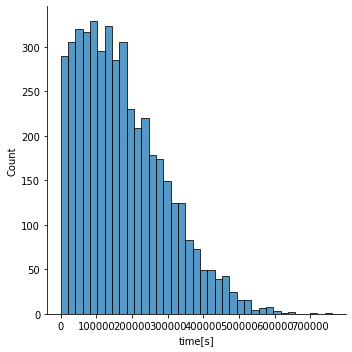

In [13]:
plt.figure(figsize=(20,10))
sns.displot(preped["time[s]"])

<Figure size 1440x720 with 0 Axes>

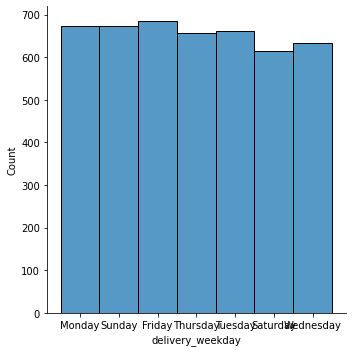

In [14]:
#map purchase timestamp to days for distplot
plt.figure(figsize=(20,10))
sns.displot(preped["delivery_weekday"])
plt.show()
# average time by day?
# plt.figure(figsize=(20,10))
# days = ['Monday' 'Sunday' 'Friday' 'Thursday' 'Tuesday' 'Saturday' 'Wednesday']
# avg_time_by_day = [np.average(preped[preped["delivery_weekday"]==day]["time[s]"]) for day in days]
# sns.lineplot(x=days, y=avg_time_by_day)
# plt.show()

Paczki są dostarczane równomiernie w całym tygodniu. Jest to dziwne ze względu na dostarczanie paczek również w niedziele.
Trzeba będzie te kwestie omówić z klientem.

Wydaje się, że dodanie dnia tygodnia jak nowego atrybutu może być przydatne do regresji.

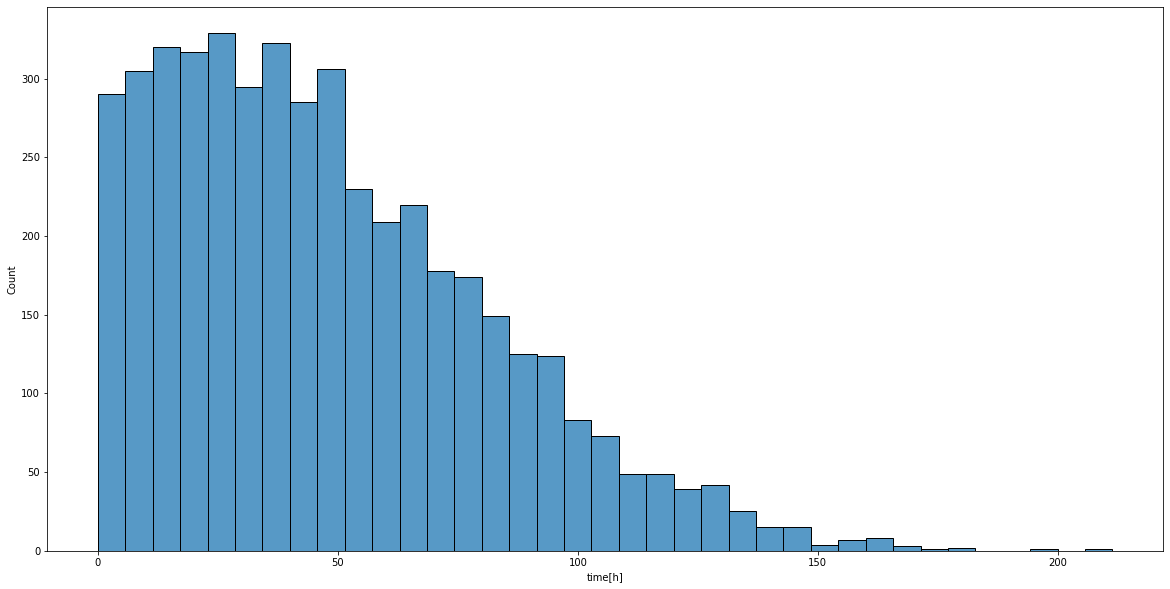

In [15]:
plt.figure(figsize=(20,10))
sns.histplot(preped["time[h]"])
plt.show()

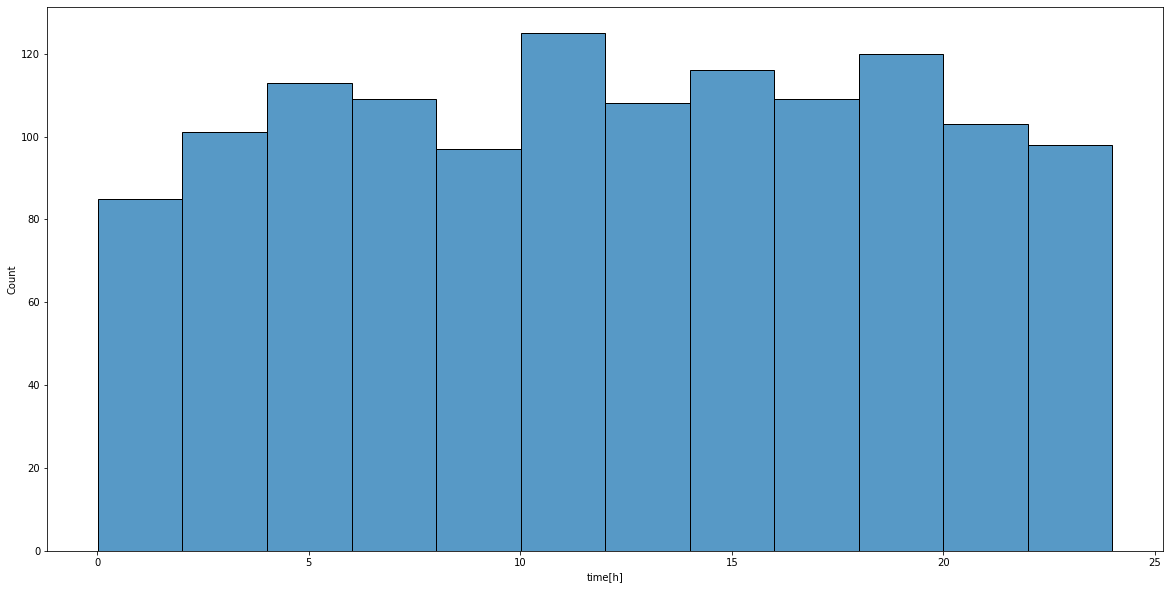

In [16]:
plt.figure(figsize=(20,10))
sns.histplot(preped[preped["time[h]"] < 24]["time[h]"])
plt.show()

Na pierwszy rzut oka martwiące są czasy dostawy poniżej godziny, ale także te krótkie - 2 lub 3 - godzinne.
Obecnym standardem w e-commerce jest dostawa przesyłki w ciągu 1-2 dni roboczych,
czyli czas dostawy od mniej więcej 10 do 30-kilku godzin. Być może te krótkie dane są poprawne, jeśli firma realizuje
dostawy ekspresowe (np. z usługą dostawy tego samego dnia) albo np. możliwość odbioru towaru z salonu, jeśli jest on w nim dostępny.

Podejrzanie krótkie czasy dostawy (poniżej 5 godzin) zdecydowanie wymagają wyjaśnienia z przedstawicielem firmy.

Warto jeszcze sprawdzić jak wygląda rozkład czasu dostawy w godzinach w podziale na poszczególne
firmy kurierskie-być może okaże się, że krótkie dostawy są realizowane tylko przez jedną firmę,
co wskazywałoby na prawidłowość hipotezy o możliwości wykupienia ekspresowej dostawy.

Ponadto warto też przyjrzeć się godzinom, w jakich realizowana jest dostawa-jest szansa,
że znajdziemy tam jakieś dostawy w nieprzyzwoicie nocnych godzinach.

Dane nt. czasu dostawy wymagają dokładniejszego przyjrzenia się ich rozkładowi.

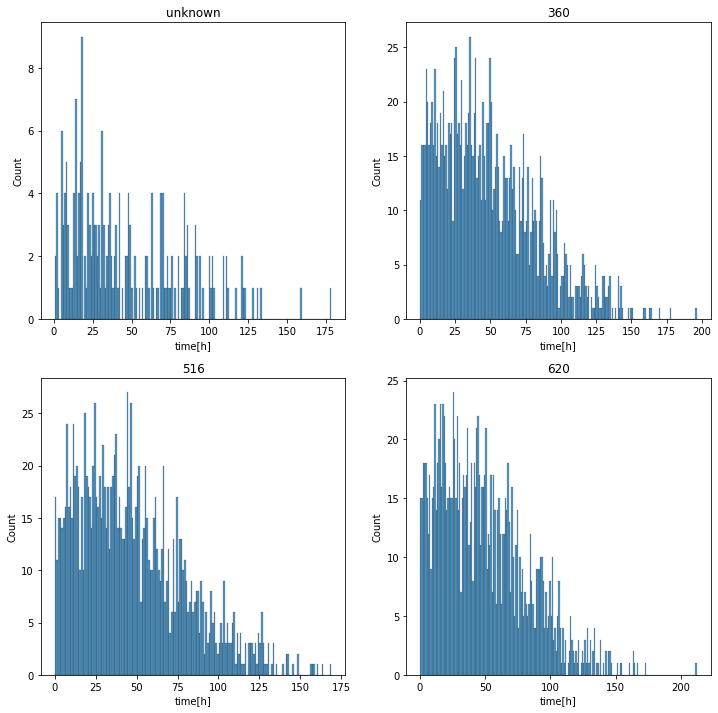

In [17]:
companies = preped["delivery_company"].unique()
dfs = {
    "unknown": preped[preped['delivery_company'].isna()]["time[h]"],
    "360": preped[preped['delivery_company']==360]["time[h]"],
    "516": preped[preped['delivery_company']==516]["time[h]"],
    "620": preped[preped['delivery_company']==620]["time[h]"]
}

fgs, axes = plt.subplots(2, 2, figsize=(12,12))
axs = [axes[i][j] for i in [0,1] for j in [0,1]]
i=0
for key, df in dfs.items():
  sns.histplot(data = df, binwidth=1, ax = axs[i])
  axs[i].title.set_text(key)
  i+=1
plt.show()

Nie wydaje się, żeby któraś z firm kurierskich dostarczała paczki znacznie szybciej od innych.

In [18]:
night_deliveries = pd.DataFrame({"id": preped["purchase_id"].to_list()}, index=pd.DatetimeIndex(preped["delivery_timestamp"])).between_time("22:00", "6:00")
print(len(night_deliveries))

1568


Z danych wynika, że paczki są dostarczane nawet w nocy. Jest to bardzo mało prawdopobone i musi być omówione z klientem.

In [19]:
users_v1["city"].unique().tolist()


['Konin',
 'Kutno',
 'Radom',
 'Police',
 'Szczecin',
 'Warszawa',
 'Gdynia',
 'Mielec']

Paczki są dostarczane do miast w różnych rejonach Polski. Bardzo małe czasy dostawy w takiej sytuacji muszą wynikać z
błędu lub paczki są wysyłane z wielu miejsc.

### Sprawdzenie dostępnych kategorii produktów

In [20]:
categories = set()
for value in products_v1["category_path"]:
  categories.update(value.split(";"))
categories

{'Akcesoria telefoniczne',
 'Anteny RTV',
 'Audio',
 'Biurowe urządzenia wielofunkcyjne',
 'Drukarki i skanery',
 'Gry PlayStation3',
 'Gry Xbox 360',
 'Gry i konsole',
 'Gry komputerowe',
 'Gry na konsole',
 'Komputery',
 'Monitory',
 'Monitory LCD',
 'Odtwarzacze DVD',
 'Odtwarzacze mp3 i mp4',
 'Okulary 3D',
 'Przenośne audio i video',
 'Sprzęt RTV',
 'Słuchawki',
 'Tablety',
 'Tablety i akcesoria',
 'Telefony i akcesoria',
 'Telefony komórkowe',
 'Telefony stacjonarne',
 'Telewizory i akcesoria',
 'Video',
 'Zestawy głośnomówiące',
 'Zestawy słuchawkowe'}

Po przyjrzeniu się kategoriom można zauważyć, że gabaryty sprzedawanych przedmiotów nie będą się bardzo różnić-
choć transport monitorów LCD i słuchawek jest różny, to raczej nie dość różny, by wpłynąć na czas dostawy.
Mimo to można dodać kolumnę dzielącą przedmioty na większe np. Drukarki i skaner, Komputery, Monitory i Monitory LCD
jako urządzenia „duże", a telefony komórkowe, zestawy słuchawkowe i gry na konsole jako „małe".

### Wnioski

Dane, które wydają się mieć znaczenie, nie wyglądają najlepiej. Kontakt z klientem i wyjaśnienie podstawowych kwestii będzie kluczowe.

Po wstępnym obejrzeniu danych, z klientem należy ustalić następujące szczegóły:
- miejsce wysyłki paczek i jego adres
- trasa paczki
- dostępność produktów w sklepie

Wszystkie te kwestie mogą wpłynąć na czas dostawy.

Ważną kwestią będzie także zapytanie o uzupełnienie brakujących danych - dane o czasie dostawy są dla nas kluczowe
oraz o błędne dane - krótkie czasy dostawy, ujemne czasy dostawy, dostawy w nocy.

## Analiza pierwszej aktualizacji zbioru danych

- odpowiedzi od klienta/krotki opis aktualizacji danych

- sprawdzenie czy poprawiono poprzednie problemy

- sprawdzenie czy istnieja elementy odstajace

- sprawdzenie rozkladow?

- tutaj wnioski

- tutaj pytania ktore trzeba zadac do klienta

- heatmap

- sprawdzenie powiazania wszystkiego ze zmienna celu?????????????????????????????????????????????????

- typ i wartosci wybranych atrybutow

- ustalenie wejscia do modelu ?

- sprawdzenie powiazania wejscia ze zmienna celu ?

### Opis informacji od klienta

Od klienta dowiedzieliśmy się, że istnieje jeden centralny magazyn ( nie ma jego adresu ), nie istnieją żadne miejsca
na ścieżce produktu do klienta, nie istnieje żaden czas oczekiwania na wysłanie, można kupic produkty tylko dostępne.

Dostaliśmy takę aktualizację danych po przedstawieniu problemów jakie w nich znaleźliśmy.

In [21]:
deliveries_v2 = pd.read_json(deliveries_v2_path, lines=True)
sessions_v2 = pd.read_json(sessions_v2_path, lines=True)
users_v2 = pd.read_json(users_v2_path, lines=True)
products_v2 = pd.read_json(products_v2_path, lines=True)

data_v2 = {"products": products_v2, "sessions": sessions_v2, "users": users_v2, "deliveries":deliveries_v2}

##### Lączenie tabel w jedną tabele

In [22]:
sessions_purchases = sessions_v2[sessions_v2["purchase_id"].notnull()].copy()
print(sessions_purchases.shape, sessions_v2.shape)

(7812, 7) (42883, 7)


In [23]:
merged = pd.merge(sessions_purchases, deliveries_v2, on='purchase_id', how = "outer")
print(deliveries_v2.shape, sessions_purchases.shape, merged.shape) #sanity check

print(merged.isnull().sum())
merged.head()

(7812, 4) (7812, 7) (7812, 10)
session_id              0
timestamp               0
user_id               402
product_id            384
event_type              0
offered_discount        0
purchase_id             0
purchase_timestamp      0
delivery_timestamp      0
delivery_company        0
dtype: int64


,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id,purchase_timestamp,delivery_timestamp,delivery_company
0,100002,2021-04-01 15:52:47,102.0,1234.0,BUY_PRODUCT,0,20001.0,2021-04-01T15:52:47,2021-04-02T14:06:34.432964,620
1,100003,2021-04-01 02:26:23,102.0,1289.0,BUY_PRODUCT,15,20002.0,2021-04-01T02:26:23,2021-04-02T10:45:27.707128,360
2,100004,2021-01-03 05:11:17,102.0,1009.0,BUY_PRODUCT,0,20003.0,2021-01-03T05:11:17,2021-01-04T15:43:07.635371,620
3,100005,2021-02-17 12:59:54,NaN,1001.0,BUY_PRODUCT,5,20004.0,2021-02-17T12:59:54,2021-02-18T11:52:42.608746,620
4,100006,2021-02-13 09:17:52,102.0,1057.0,BUY_PRODUCT,5,20005.0,2021-02-13T09:17:52,2021-02-15T08:59:28.973167,620


In [24]:
merged2 = pd.merge(merged, users_v2, on="user_id", how = "outer")
print(merged.shape, users_v2.shape, merged2.shape)
print(merged2.isnull().sum())
merged2.head()

(7812, 10) (200, 4) (7812, 13)
session_id              0
timestamp               0
user_id               402
product_id            384
event_type              0
offered_discount        0
purchase_id             0
purchase_timestamp      0
delivery_timestamp      0
delivery_company        0
name                  402
city                  402
street                402
dtype: int64


,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id,purchase_timestamp,delivery_timestamp,delivery_company,name,city,street
0,100002,2021-04-01 15:52:47,102.0,1234.0,BUY_PRODUCT,0,20001.0,2021-04-01T15:52:47,2021-04-02T14:06:34.432964,620,Aurelia Malon,Police,pl. Brzoskwiniowa 11/53
1,100003,2021-04-01 02:26:23,102.0,1289.0,BUY_PRODUCT,15,20002.0,2021-04-01T02:26:23,2021-04-02T10:45:27.707128,360,Aurelia Malon,Police,pl. Brzoskwiniowa 11/53
2,100004,2021-01-03 05:11:17,102.0,1009.0,BUY_PRODUCT,0,20003.0,2021-01-03T05:11:17,2021-01-04T15:43:07.635371,620,Aurelia Malon,Police,pl. Brzoskwiniowa 11/53
3,100006,2021-02-13 09:17:52,102.0,1057.0,BUY_PRODUCT,5,20005.0,2021-02-13T09:17:52,2021-02-15T08:59:28.973167,620,Aurelia Malon,Police,pl. Brzoskwiniowa 11/53
4,100007,2021-01-15 15:42:34,102.0,1072.0,BUY_PRODUCT,0,20006.0,2021-01-15T15:42:34,2021-01-16T18:09:23.624555,516,Aurelia Malon,Police,pl. Brzoskwiniowa 11/53


In [25]:
merged_full = pd.merge(merged2, products_v2, on="product_id", how = "left")
print(merged2.shape, users_v2.shape, merged_full.shape)
print(merged_full.isnull().sum())
merged_full.head()

(7812, 13) (200, 4) (7812, 16)
session_id              0
timestamp               0
user_id               402
product_id            384
event_type              0
offered_discount        0
purchase_id             0
purchase_timestamp      0
delivery_timestamp      0
delivery_company        0
name                  402
city                  402
street                402
product_name          384
category_path         384
price                 384
dtype: int64


,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id,purchase_timestamp,delivery_timestamp,delivery_company,name,city,street,product_name,category_path,price
0,100002,2021-04-01 15:52:47,102.0,1234.0,BUY_PRODUCT,0,20001.0,2021-04-01T15:52:47,2021-04-02T14:06:34.432964,620,Aurelia Malon,Police,pl. Brzoskwiniowa 11/53,Sony DVP-SR760,Sprzęt RTV;Video;Odtwarzacze DVD,193.00
1,100003,2021-04-01 02:26:23,102.0,1289.0,BUY_PRODUCT,15,20002.0,2021-04-01T02:26:23,2021-04-02T10:45:27.707128,360,Aurelia Malon,Police,pl. Brzoskwiniowa 11/53,Philips SDV5225,Sprzęt RTV;Video;Telewizory i akcesoria;Anteny...,129.00
2,100004,2021-01-03 05:11:17,102.0,1009.0,BUY_PRODUCT,0,20003.0,2021-01-03T05:11:17,2021-01-04T15:43:07.635371,620,Aurelia Malon,Police,pl. Brzoskwiniowa 11/53,Kinect Joy Ride (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,69000000.00
3,100006,2021-02-13 09:17:52,102.0,1057.0,BUY_PRODUCT,5,20005.0,2021-02-13T09:17:52,2021-02-15T08:59:28.973167,620,Aurelia Malon,Police,pl. Brzoskwiniowa 11/53,Doom 3 (PC),Gry i konsole;Gry komputerowe,19.99
4,100007,2021-01-15 15:42:34,102.0,1072.0,BUY_PRODUCT,0,20006.0,2021-01-15T15:42:34,2021-01-16T18:09:23.624555,516,Aurelia Malon,Police,pl. Brzoskwiniowa 11/53,Jabra Freeway,Telefony i akcesoria;Akcesoria telefoniczne;Ze...,299.00


Po połączeniu wszystkich dostępnych danych w jedną megatabelę widać, że do 402 dostaw brakuje kluczowych informacji o adresie dostawy (wynika to z braków w tabeli sessions, gdzie w miejscu id użytkownika była wartość pusta). To dość niewiele rekordów w porównaniu z całym rozmiarem zbioru danych, więc jeśli nie będzie dało się ich uzupełnić to będzie można po prostu zrezygnować z tych wierszy i nie wykorzystywać ich do predykcji. 


### Sprawdzenie poprzednich problemów

#### Braki danych

In [26]:
for key, value in data_v1.items():
  print(key, ":\n", value.isnull().sum(), "\n")

products :
 product_id       0
product_name     0
category_path    0
price            0
dtype: int64 

sessions :
 session_id              0
timestamp               0
user_id              1915
product_id           1913
event_type              0
offered_discount        0
purchase_id         30697
dtype: int64 

users :
 user_id    0
name       0
city       0
street     0
dtype: int64 

deliveries :
 purchase_id             0
purchase_timestamp      0
delivery_timestamp    333
delivery_company      329
time_difference       333
dtype: int64 



In [27]:
for key, value in data_v2.items():
  print(key, ":\n", value.isnull().sum(), "\n")


products :
 product_id       0
product_name     0
category_path    0
price            0
dtype: int64 

sessions :
 session_id              0
timestamp               0
user_id              2174
product_id           2101
event_type              0
offered_discount        0
purchase_id         35071
dtype: int64 

users :
 user_id    0
name       0
city       0
street     0
dtype: int64 

deliveries :
 purchase_id           0
purchase_timestamp    0
delivery_timestamp    0
delivery_company      0
dtype: int64 



Braki w kluczowej tabeli "deliveries" zostały uzupełnione. Zwiększyła się liczba braków w tabeli „sessions", ale
nie powinno być to dla nas problemem. Te dane wydają się mało istotne dla naszego problemu.

#### Błędy danych

In [28]:
deliveries_v2["purchase_timestamp"] = pd.to_datetime ( deliveries_v2["purchase_timestamp"], format='%Y-%m-%dT%H:%M', errors="coerce")
deliveries_v2['delivery_timestamp'] = pd.to_datetime ( deliveries_v2["delivery_timestamp"], format='%Y-%m-%dT%H:%M:%S', errors="coerce")
deliveries_v2["time_difference"] = deliveries_v2["delivery_timestamp"] - deliveries_v2["purchase_timestamp"]

##### Ujemne czasy dostawy

In [29]:
len(deliveries_v2[deliveries_v2["purchase_timestamp"] > deliveries_v2["delivery_timestamp"]])

0

Na szczęście dane ze złym czasem dostawy zostały poprawione.

##### Nocne dostawy

In [30]:
night_deliveries = pd.DataFrame({"id": deliveries_v2["purchase_id"].to_list()}, index=pd.DatetimeIndex(deliveries_v2["delivery_timestamp"])).between_time("22:00", "6:00")
print(len(night_deliveries))


0


Dostawy w nocy już nie występują.

##### Dostawy w niedziele

<Figure size 1440x720 with 0 Axes>

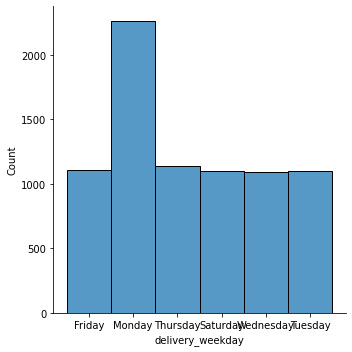

In [31]:
preped = deliveries_v2.copy()
preped["delivery_weekday"]=preped['delivery_timestamp'].dt.day_name()

plt.figure(figsize=(20,10))
sns.displot(preped["delivery_weekday"])
plt.show()

Dostawy w niedzielę już nie występują. Widać, że dostawy w poniedziałki występują teraz około dwóch razy częściej
niż te w inne dni tygodnia.

##### Krótkie dostawy

In [32]:
len(deliveries_v2[deliveries_v2["time_difference"] < pd.Timedelta(hours=12)])

65

Krótkie czasy dostawy ( poniżej dwunastu godzin ) nadal występują, ale jest to niecały procent danych.

### Sprawdzanie powiązań między zmiennymi i wstępny wybór danych wejściowych

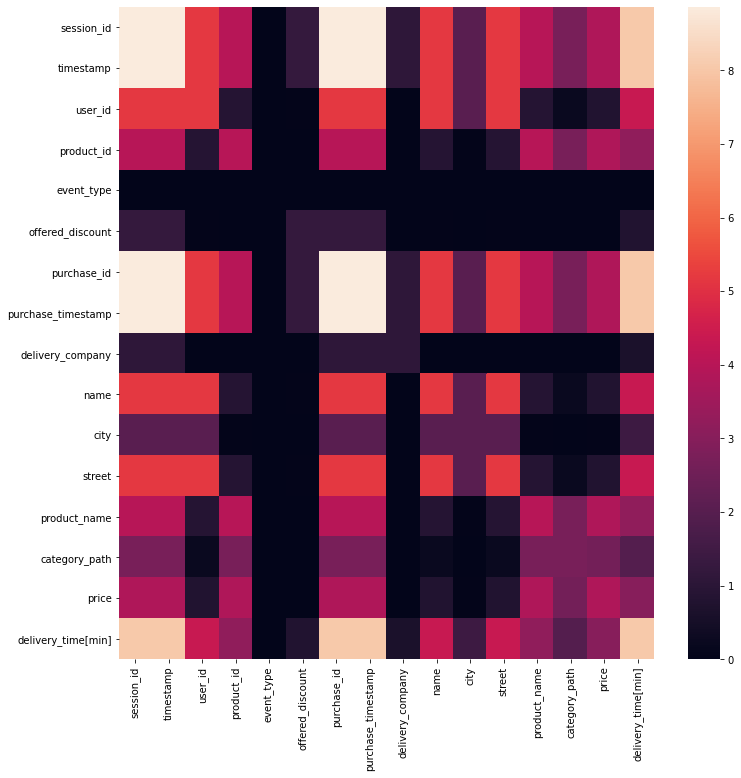

In [33]:
from sklearn.metrics import mutual_info_score

def calc_mutual_info_score(df):
  attributes = df.columns.to_list()
  scores = pd.DataFrame(data = np.zeros((len(attributes), len(attributes))), columns = attributes, index = attributes)
  for i in range(len(attributes)):
    for j in range(i, len(attributes)):
      at1 = attributes[i]
      at2 = attributes[j]
      mi_score = mutual_info_score(df[at1], df[at2])
      scores[at1][at2] = mi_score
      scores[at2][at1] = mi_score
  return scores

#data prep
merged_full["purchase_timestamp"] = pd.to_datetime ( merged_full["purchase_timestamp"], format='%Y-%m-%dT%H:%M', errors="coerce")
merged_full['delivery_timestamp'] = pd.to_datetime ( merged_full["delivery_timestamp"], format='%Y-%m-%dT%H:%M:%S', errors="coerce")
merged_full["delivery_time[min]"] = (merged_full['delivery_timestamp'] - merged_full["purchase_timestamp"]).apply(lambda x: x.total_seconds()//60)
temp = merged_full.drop(labels=["delivery_timestamp"], axis=1)
temp = temp.dropna()

mi_scores = calc_mutual_info_score(temp)
plt.figure(figsize=(12,12))
sns.heatmap(mi_scores)

In [34]:
print("Identical timestamps for purchase and session: ",len(merged_full[merged_full["timestamp"] == merged_full["purchase_timestamp"]]))
print("Different session events: ", merged_full["event_type"].nunique())
print("Different session_ids: ", merged_full["session_id"].nunique())
print("Different purchase_ids: ", merged_full["purchase_id"].nunique())
print("Different buy timestamps: ", merged_full["timestamp"].nunique())

Identical timestamps for purchase and session:  7812
Different session events:  1
Different session_ids:  7812
Different purchase_ids:  7812
Different buy timestamps:  7809


In [35]:
merged_full["purchase_day_of_week"] = merged_full["purchase_timestamp"].apply(lambda x: x.day_name())
merged_full["purchase_hour"] = merged_full["purchase_timestamp"].apply(lambda x: x.hour)


Ze zbioru danych wejściowych możemy na pewno na wstępie odrzucić atrybuty:
- event_type, gdyż jest tylko jeden ("BUY_EVENT"),
- session_id i purchase id, gdyż każdy zakup  ma je unikatowe,
- timestamp, bo jest identyczny do purchase_timestamp, a nie potrzebujemy idealnie zduplikowanych danych, 
- purchase timestamp, bo przyjmuje niemal zawsze unikatowe wartości.

Atrybuty "timestamp" i "purchase_timestamp" zastąpione zostaną atrybutami "purchase_day_of_week" (dzień tygodnia) i "purchase_hour" (godzina zakupu zaokrąglona w dół). Spodziewamy się że te zmienne pozwolą lepiej odzwierciedlić spodziewany dobowy i godzinowy trend w rozkładzie czasu dostay. 

Ponadto z danych usunięte też będą atrybuty user_id, name i street (która zawiera nie tylko ulicę, ale też numer bloku i mieszkania konkretnego użytkownika), ponieważ nie zawierają informacji, które będą się dobrze generalizować, a raczej te identyfikujące konkretnych użytkowników. Oczywiście adres to prawdopodobnie cenna informacja, przydatna do przewidzenia czasu dostawy, jednak będzie potrzebny na większym poziomie granulacji np. miast, ulic, a może rejonów związanych z kodami pocztowymi. 

Atrybuty, które planujemy pozostawić w modelu: 
product_id, offered_discount, delivery_company, city, 
product_name, category_path, price, purchase_day_of_week, purchase_hour.

Atrybutem wyjściowym modelu będzie: delivery_time[min], obliczany z danych jako różnica czasu pomiędzy delivery_timestamp i purchase_timestamp, zaokrąglona do minut. Z tak wyliczonej różnicy czasowej będzie można później z łatwością wyliczyć przewidywany czas dostawy i zaprezentować klientowi.

In [36]:
selected = merged_full[['product_id', 'offered_discount', 'delivery_company', 
                     'city', 'product_name', 'category_path', 'price',
                     'purchase_day_of_week', 'purchase_hour', 'delivery_time[min]']]       
target = 'delivery_time[min]'         

,product_id,offered_discount,delivery_company,city,product_name,category_path,price,purchase_day_of_week,purchase_hour,delivery_time[min]
product_id,3.998606,0.018381,0.010912,0.042108,3.998606,2.706870,3.822205,0.032310,0.137268,3.209581
offered_discount,0.018381,1.241218,0.000506,0.001786,0.018381,0.003504,0.015485,0.001270,0.007211,0.783091
delivery_company,0.010912,0.000506,1.098610,0.001607,0.010912,0.002128,0.009661,0.001007,0.003787,0.623090
city,0.042108,0.001786,0.001607,2.054569,0.042108,0.007248,0.035853,0.004273,0.012005,1.450433
product_name,3.998606,0.018381,0.010912,0.042108,3.998606,2.706870,3.822205,0.032310,0.137268,3.209581


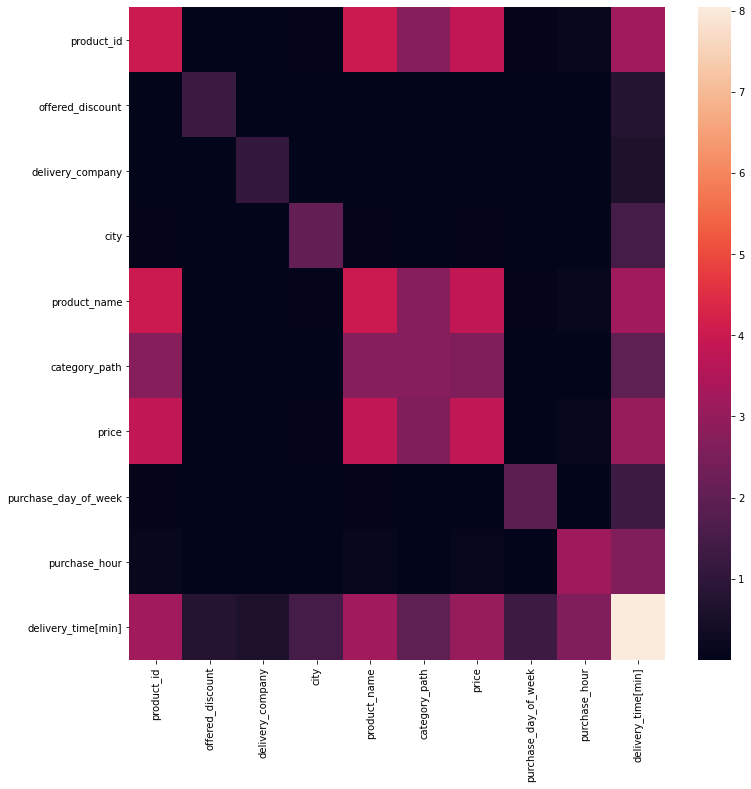

In [39]:
selected = selected.dropna()
mi_scores = calc_mutual_info_score(selected)
plt.figure(figsize=(12,12))
sns.heatmap(mi_scores)

### Drzewo decyzyjne

In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import median_absolute_error
from sklearn.preprocessing import LabelEncoder


x_train, x_test, y_train, y_test = train_test_split(
    selected.drop(target, axis=1),selected[target], random_state=23, test_size=0.2)

categoricals = x_train.select_dtypes(object).columns.to_list()
encoder = LabelEncoder()
for c in categoricals:
  x_train.loc[:,c] = encoder.fit_transform(x_train[c].astype(str))
  x_test.loc[:,c] = encoder.transform(x_test[c].astype(str))



reg = LinearRegression()
reg.fit(x_train, y_train)
pred_train = reg.predict(x_train)
pred_test = reg.predict(x_test)

train_score = median_absolute_error(pred_train, y_train)
test_score = median_absolute_error(pred_test, y_test)
print(f'Train Median absolute error: {train_score}, test Median absolute error: {test_score}')
#print(pred_train, y_train)

Train Median absolute error: 780.3592599998249, test Median absolute error: 803.5931909265801
